TO DO
- (check) automatic detection of traffic light period length
- (check) automatic detection of Breakpoints A, B, C [For C: check wether C is a maximum!!!] Tweak parameter back: period= 0.5!!
- (check) store the important time values in a list? dict? series? just variables?
- (check)identify the densities from the traffic simulation (use e2 detector)
- implement queue length estimation for short queues (no breakpoint A; assume that all vehicles can leave the lane -> no queue left after green lights phase) --> check f the start:end points are right!! Measure the nVehLeft over green light period to get the flow -> you can also use directly nVehLeft and estimate the queue
- calculate the prediciton of queue length (for the for every traffic lights phase in a loop) 
- compare estimated queue length with e2 detector data

In [61]:
from trafficgraphnn.sumo_network import SumoNetwork
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# setup: create an object that represents all information associated with a Sumo road network and its output data
#sn = SumoNetwork(
#    'data/networks/testgrid2/testgrid2.net.xml', routefile='data/networks/testgrid2/testgrid2_rand_routes.routes.xml',
#    lanewise=True, addlfiles=['data/networks/testgrid2/testgrid2_e2.add.xml', 'data/networks/testgrid2/testgrid2_e1.add.xml', 'data/networks/testgrid2/tls_output.add.xml']
#)

#sn = SumoNetwork(
#    'data/networks/new_test/new_test.net.xml', routefile='data/networks/new_test/new_test_rand_routes.routes.xml',
#    lanewise=True, addlfiles=['data/networks/new_test/new_test_e2.add.xml', 'data/networks/new_test/new_test_e1.add.xml','data/networks/new_test/tls_output.add.xml']
#)

sn = SumoNetwork(
    'data/networks/one_intersection/one_intersection.net.xml', routefile='data/networks/one_intersection/one_intersection_rand_routes.routes.xml',
    lanewise=True, addlfiles=['data/networks/one_intersection/one_intersections_additionals.add.xml', 'data/networks/one_intersection/tls_output.add.xml']
)

sn.run()
sn.load_data_to_graph()
graph = sn.get_graph()

2018-05-31 14:33:23,312 trafficgraphnn.sumo_network WARNING  Seed not set, SUMO seed will be random.


In [62]:
command = sn.get_sumo_command()
' '.join(command)

2018-05-31 14:33:30,098 trafficgraphnn.sumo_network WARNING  Seed not set, SUMO seed will be random.


'sumo --net-file data/networks/one_intersection/one_intersection.net.xml --route-files data/networks/one_intersection/one_intersection_rand_routes.routes.xml --no-step-log --additional-files data/networks/one_intersection/one_intersections_additionals.add.xml,data/networks/one_intersection/tls_output.add.xml --random true'

In [63]:
# Pick a lane to observe
#lane = '0/0to0/1_0'
lane = '1/3to1/2_0'

df_detector = pd.DataFrame()
df_detector = graph.node[lane]['detectors']['e1_1-3to1-2_0_1']['data_series']
#df_detector = graph.node[lane]['detectors']['e1_0-0to0-1_0_0']['data_series']

df_rows, df_columns = df_detector.shape #get rows and columns
#print(df_detector.loc[:, 'flow'])
#graph.node[lane]['detectors']['e1_0-0to0-1_0_0']['data_series']
#graph.node[lane]['detectors']['e1_1-3to1-2_0_1']['data_series']

In [64]:
### plot flow on e1 detector

#num_phase = 20
#phase_length = int(df_traffic_lights['begin'].values[1] - df_traffic_lights['begin'].values[0])
#duration_green_light = int(df_traffic_lights['duration'].values[0])

#start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
#end = start + phase_length #seconds #end is end of green phase

#plt.plot(df_detector['end'], df_detector["flow"], c='b', )
#plt.xlim(1500, 2000)
#plt.show()

In [65]:
#### Embed the trafficlights #####

graph.edges(lane)
lane_out = '1/2to1/1_1' #choose which connection data you want
df_traffic_lights = graph.edges[(lane, lane_out)]['switch_times'] 
#df_traffic_lights


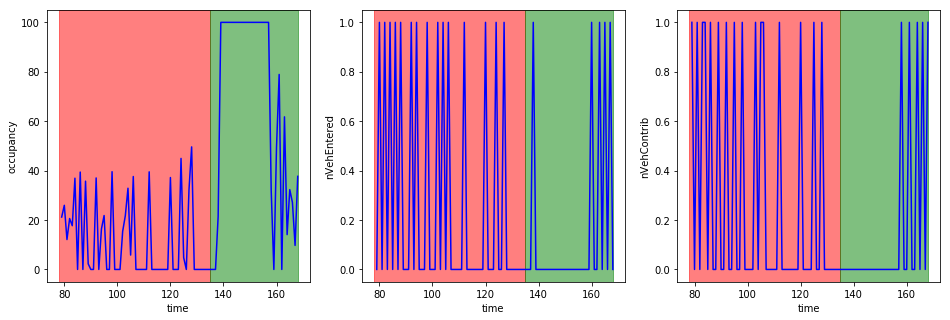

In [66]:
num_phase =0 # select the number of phase
phase_length = int(df_traffic_lights['begin'].values[1] - df_traffic_lights['begin'].values[0])
duration_green_light = int(df_traffic_lights['duration'].values[0])

start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
end = start + phase_length #seconds #end is end of green phase

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(16)

plt.subplot(1, 3, 1)
# Plot occupancy over time
plt.plot(df_detector['end'][start:end], df_detector["occupancy"][start:end], c='b', )
# Label the graph axes.
plt.ylabel("occupancy")
plt.xlabel("time")
plt.axvspan(start, end-33, alpha=0.5, color='red')
plt.axvspan(end-33, end, alpha=0.5, color='green')


plt.subplot(1, 3, 2)
#Plot nVehEntered over time
plt.plot(df_detector['end'][start:end], df_detector["nVehEntered"][start:end], c='b')
plt.ylabel("nVehEntered")
plt.xlabel("time")
plt.axvspan(start, end-33, alpha=0.5, color='red')
plt.axvspan(end-33, end, alpha=0.5, color='green')


plt.subplot(1, 3, 3)
# Plot nVehContrib over time --> The number of vehicles that have completely passed the detector within the interval 
plt.plot(df_detector['end'][start:end], df_detector["nVehContrib"][start:end], c='b')
plt.ylabel("nVehContrib")
plt.xlabel("time")
plt.axvspan(start, end-33, alpha=0.5, color='red')
plt.axvspan(end-33, end, alpha=0.5, color='green')

plt.show()


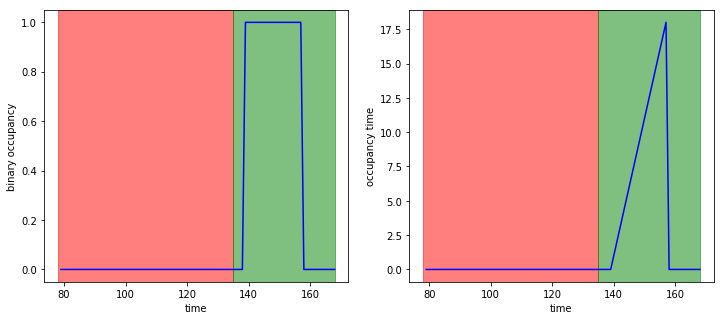

In [67]:
#Calculating Detector Occupancy Time and plot it
##Attention!!! : Works only when simulation timestep =1 second!

detector_occupancy_time = []

#print(occ_t[t].values) #debug
nVehEnter_t = df_detector.loc[:, 'nVehEntered']
nVehPassed_t = df_detector.loc[:, 'nVehContrib']

occ_t = df_detector.loc[:, 'occupancy']
binary_occ_t = pd.Series()
binary_occ_t = occ_t.apply(lambda x:(1 if x >= 100 else 0))

#Calculate effective detector occupancy time
cnt=0
for t in range(0, df_rows):
    if binary_occ_t[t].values[0]==0:
        detector_occupancy_time.append(0)
    else:
        if binary_occ_t[t+1].values[0] == 1:
            detector_occupancy_time.append(cnt)
            cnt = cnt+1  
        else:
            detector_occupancy_time.append(cnt)
            cnt=0
                   
##### PLOT #####
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)
            
#Plot binary_occ_t
plt.subplot(1,2,1)
plt.plot(df_detector['end'][start:end], binary_occ_t[start:end], c='b')
plt.ylabel("binary occupancy")
plt.xlabel("time")
plt.axvspan(start, end-33, alpha=0.5, color='red')
plt.axvspan(end-33, end, alpha=0.5, color='green')
          
plt.subplot(1,2,2)
plt.plot(df_detector['end'][start:end], detector_occupancy_time[start:end], c='b')
plt.ylabel("occupancy time")
plt.xlabel("time")
plt.axvspan(start, end-33, alpha=0.5, color='red')
plt.axvspan(end-33, end, alpha=0.5, color='green')
plt.show()    
    
    
    


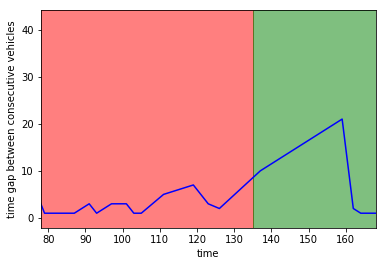

In [68]:
#Calculating the time gap between vehicles
#I am assuming that there is maximum only one vehicle per second on the detector

point_of_time = []
time_gap_vehicles = []
bool_start_timer =0
time_cnt=0

for t in range(0, df_rows):
    if nVehEnter_t[t].values[0] ==1: #new vehicle enters the detector: start timer new timer and save old measurements
        time_gap_vehicles.append(time_cnt)
        point_of_time.append(t)
        time_cnt=0 #reset time counter for new timing
        
    if nVehEnter_t[t].values[0]==0: #timer is running, following vehicle hasn't come yet
        time_cnt= time_cnt+1      

plt.plot(point_of_time, time_gap_vehicles, c='b')
plt.ylabel("time gap between consecutive vehicles")
plt.xlabel("time")
plt.xlim((start,end))
plt.axvspan(start, end-33, alpha=0.5, color='red')
plt.axvspan(end-33, end, alpha=0.5, color='green')
plt.show() 


df_time_gap=pd.DataFrame()
df_time_gap['time']=point_of_time
df_time_gap['time_gap']=time_gap_vehicles
#df_time_gap
        

got into the case A!
got into the case B!
breakpoints
137
157


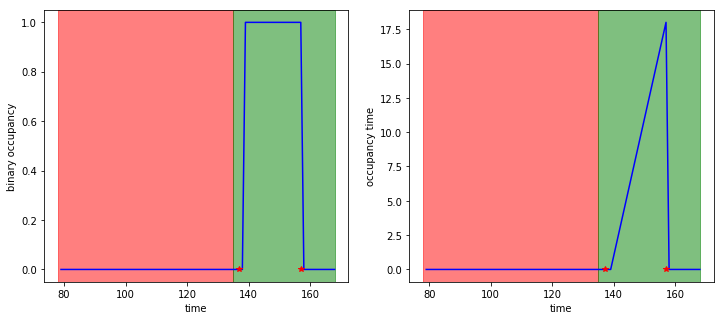

In [69]:
### Characterize the Breakpoints A,B

### A & B ### use the binary occupancy: 
#We should point out that second-by-second percentage occupancy data can also be utilized to identify point A, i.e., the occupancy value
#is kept at 100% for more than 3 s.(Liu paper, page 417)
bool_A_found = 0
bool_B_found = 0
breakpoint_A = 0
breakpoint_B = 0

for t in range(start, end):
    
    if bool_A_found == 0 and binary_occ_t[t].values[0] == 0 and binary_occ_t[t+1].values[0] == 1 and binary_occ_t[t+2].values[0] == 1 and binary_occ_t[t+3].values[0] == 1:
        breakpoint_A = t
        bool_A_found = 1
        print("got into the case A!")
        
    if bool_A_found == 1 and bool_B_found == 0 and binary_occ_t[t-3].values[0] == 1 and binary_occ_t[t-2].values[0] == 1 and binary_occ_t[t-1].values[0] == 1 and binary_occ_t[t].values[0] == 0:
        breakpoint_B = t
        bool_B_found = 1
        print("got into the case B!")

if bool_A_found == 1 and bool_B_found == 1:   
    print("breakpoints")
    print(breakpoint_A)
    print(breakpoint_B)
else:
    print("No reliable breakpoints found!")
    

##### PLOT #####
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)
            
#Plot binary_occ_t
plt.subplot(1,2,1)
plt.plot(df_detector['end'][start:end], binary_occ_t[start:end], c='b')
plt.ylabel("binary occupancy")
plt.xlabel("time")
plt.axvspan(start, end-33, alpha=0.5, color='red')
plt.axvspan(end-33, end, alpha=0.5, color='green')
if bool_A_found == 1 and bool_B_found == 1:
    plt.plot(breakpoint_A, 0, 'r*')
    plt.plot(breakpoint_B, 0, 'r*')
          
plt.subplot(1,2,2)
plt.plot(df_detector['end'][start:end], detector_occupancy_time[start:end], c='b')
plt.ylabel("occupancy time")
plt.xlabel("time")
plt.axvspan(start, end-33, alpha=0.5, color='red')
plt.axvspan(end-33, end, alpha=0.5, color='green')
if bool_A_found == 1 and bool_B_found == 1:
    plt.plot(breakpoint_A, 0, 'r*')
    plt.plot(breakpoint_B, 0, 'r*')
plt.show()  

Breakpoint C found!
Breakpoint: 178 Time Gap: 7


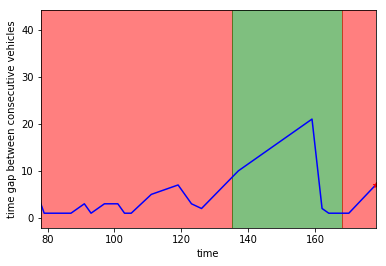

In [70]:
#Characterizing Breakpoint C using time gap between consecutive vehicles
bool_C_found =0
breakpoint_C = 0
start_search = breakpoint_B + 5 #start searching for C after the breakpoint B + seconds and until end; little offset of 5 sec is necessary to avoid influence from breakpoint B
end_search = end + 10

for k in range(0, len(point_of_time)-1):
    if point_of_time[k] >= start_search and point_of_time[k] <= end_search and time_gap_vehicles[k] >= 3 and bool_C_found ==0 and bool_B_found == 1:
        print("Breakpoint C found!")
        print("Breakpoint:", point_of_time[k], "Time Gap:", time_gap_vehicles[k])
        breakpoint_C = point_of_time[k]
        index_C = k
        bool_C_found = 1

if bool_C_found == 1:
    plt.plot(point_of_time, time_gap_vehicles, c='b')
    plt.ylabel("time gap between consecutive vehicles")
    plt.xlabel("time")
    plt.xlim((start,end_search))
    plt.axvspan(start, end-33, alpha=0.5, color='red')
    plt.axvspan(end-33, end, alpha=0.5, color='green')
    plt.axvspan(end, end_search, alpha=0.5, color='red')
    plt.plot(breakpoint_C, time_gap_vehicles[index_C], 'r*')
    plt.show() 
else:
    print("No breakpoint found!")  

breakpoints in phase 0
137
157
Breakpoint C found!
Breakpoint: 178 Time Gap: 7


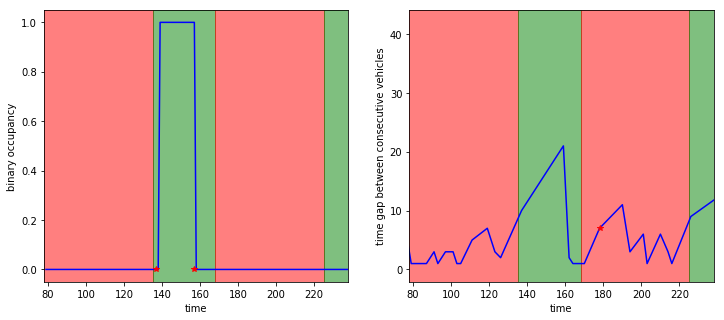

breakpoints in phase 1
244
248
Breakpoint C found!
Breakpoint: 259 Time Gap: 4


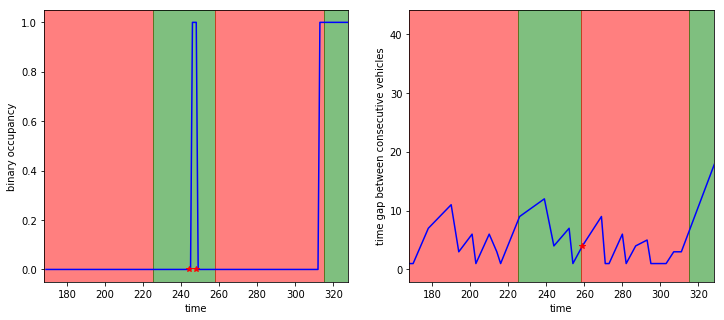

breakpoints in phase 2
311
337
Breakpoint C found!
Breakpoint: 361 Time Gap: 3


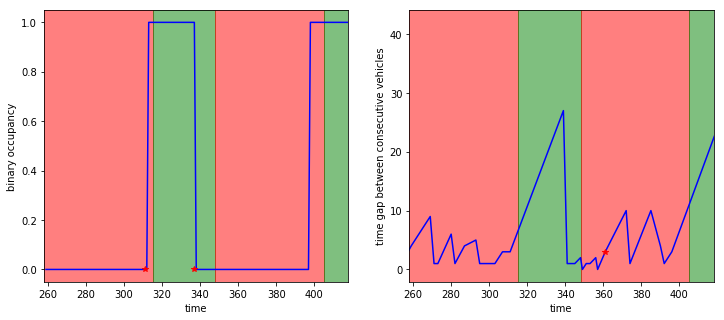

breakpoints in phase 3
396
427
Breakpoint C found!
Breakpoint: 448 Time Gap: 2


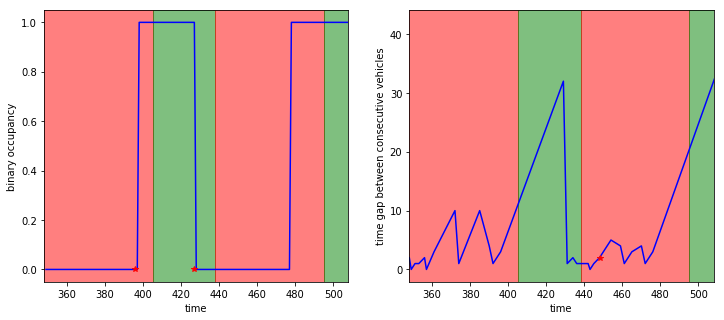

breakpoints in phase 4
476
517
Breakpoint C found!
Breakpoint: 537 Time Gap: 1


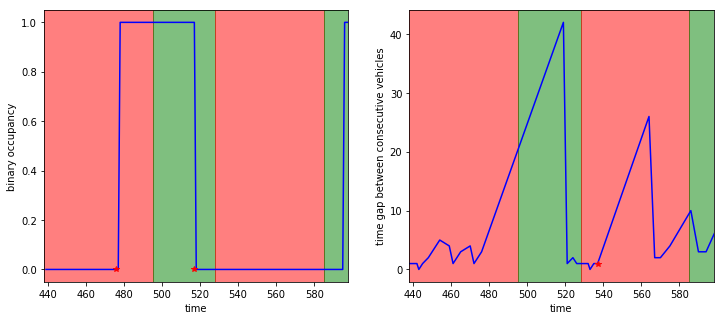

breakpoints in phase 5
594
607
Breakpoint C found!
Breakpoint: 641 Time Gap: 5


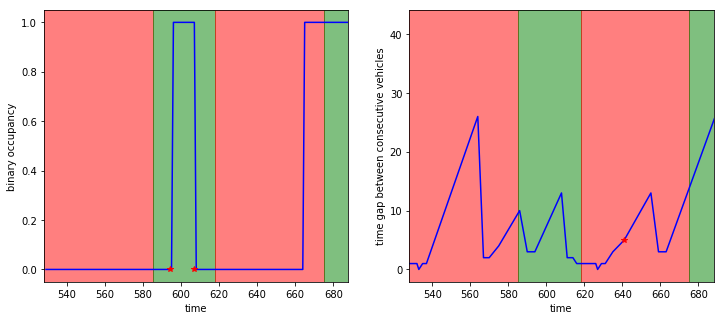

breakpoints in phase 6
663
698
Breakpoint C found!
Breakpoint: 708 Time Gap: 1


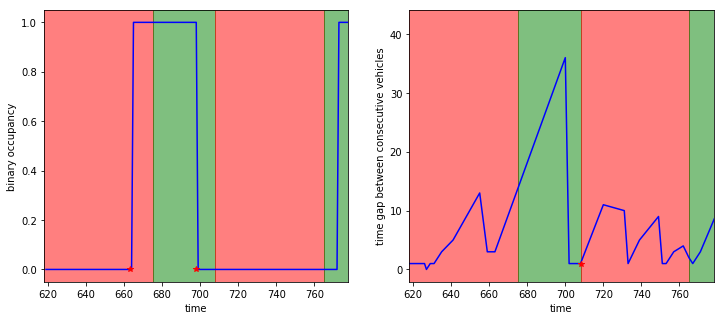

breakpoints in phase 7
771
786
Breakpoint C found!
Breakpoint: 797 Time Gap: 1


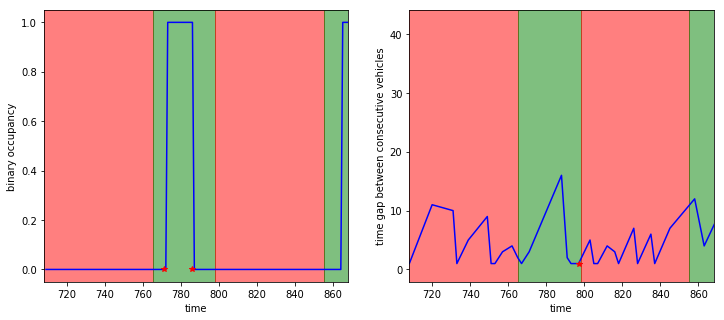

breakpoints in phase 8
863
877
Breakpoint C found!
Breakpoint: 888 Time Gap: 1


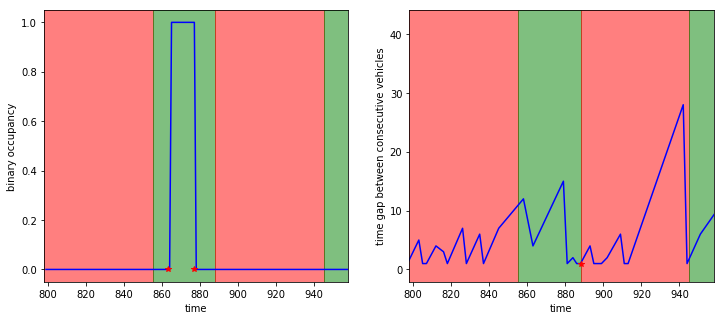

No reliable breakpoints in phase 9 found!
No breakpoint C in phase 9 found!


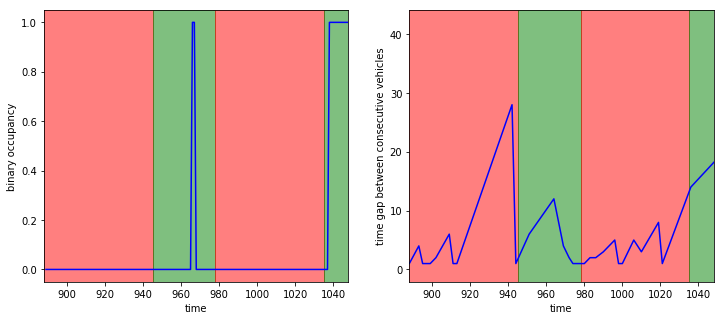

breakpoints in phase 10
1036
1058
Breakpoint C found!
Breakpoint: 1086 Time Gap: 2


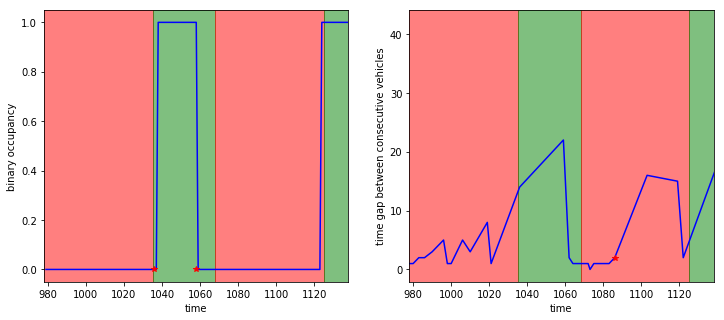

breakpoints in phase 11
1122
1146
Breakpoint C found!
Breakpoint: 1163 Time Gap: 2


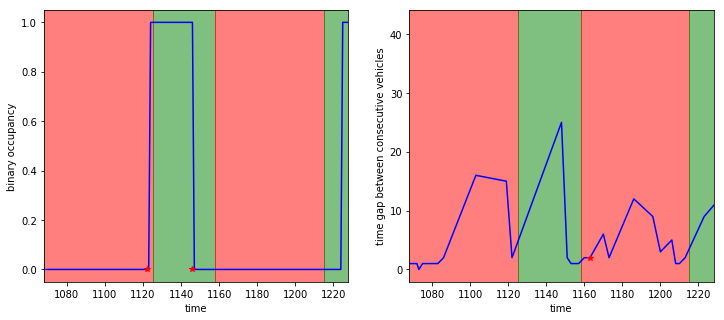

breakpoints in phase 12
1223
1237
Breakpoint C found!
Breakpoint: 1253 Time Gap: 6


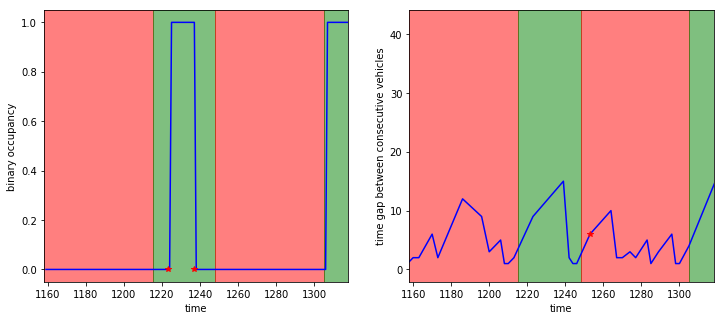

breakpoints in phase 13
1305
1327
Breakpoint C found!
Breakpoint: 1341 Time Gap: 8


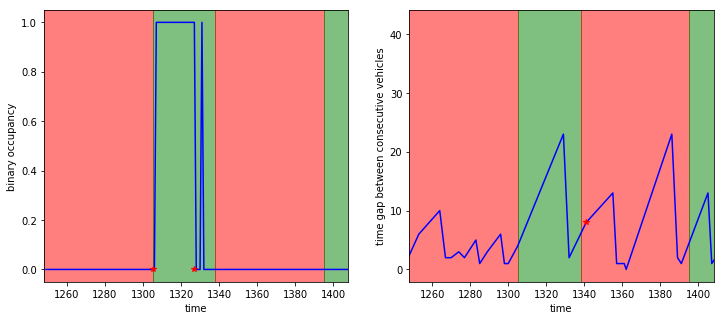

No reliable breakpoints in phase 14 found!
No breakpoint C in phase 14 found!


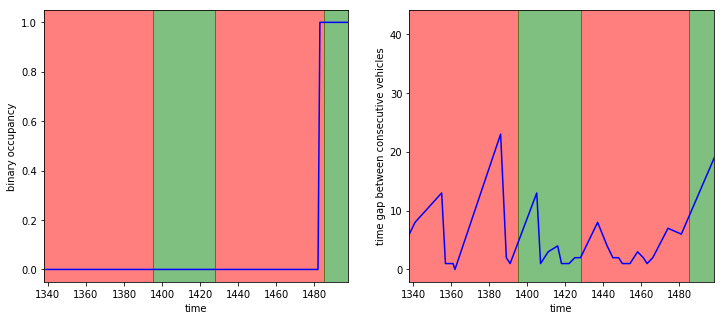

breakpoints in phase 15
1481
1508
Breakpoint C found!
Breakpoint: 1530 Time Gap: 1


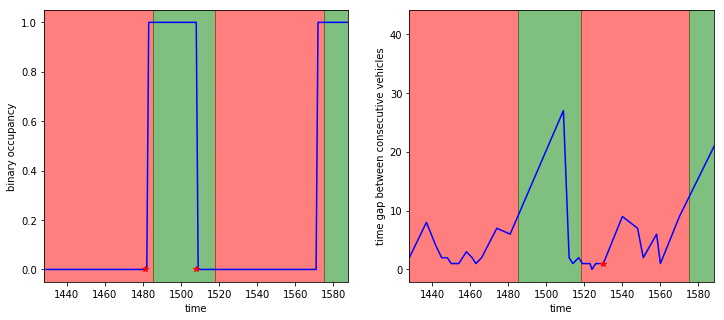

breakpoints in phase 16
1570
1597
Breakpoint C found!
Breakpoint: 1615 Time Gap: 4


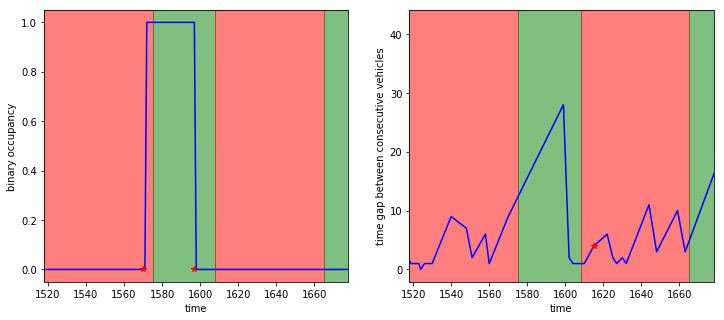

No reliable breakpoints in phase 17 found!
No breakpoint C in phase 17 found!


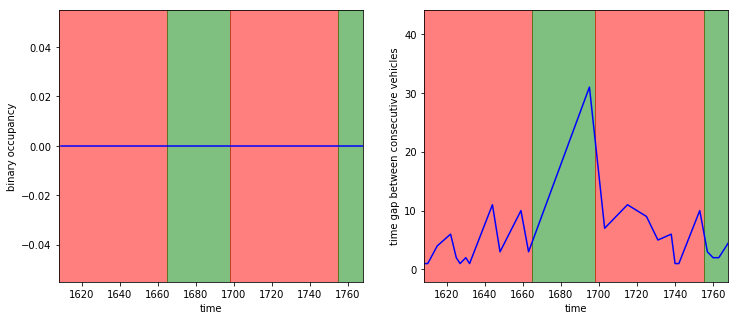

No reliable breakpoints in phase 18 found!
No breakpoint C in phase 18 found!


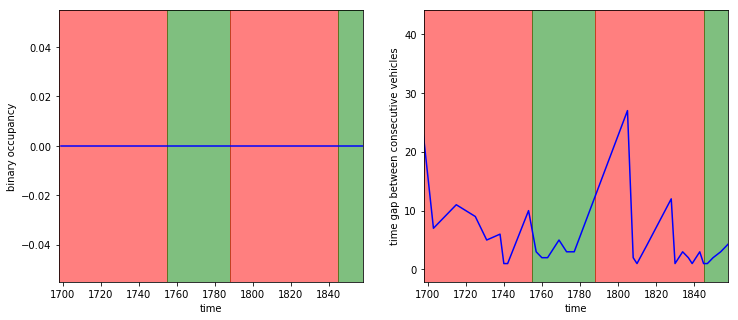

No reliable breakpoints in phase 19 found!
No breakpoint C in phase 19 found!


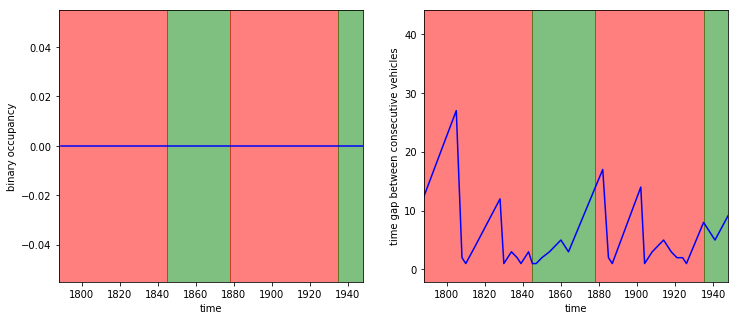

No reliable breakpoints in phase 20 found!
No breakpoint C in phase 20 found!


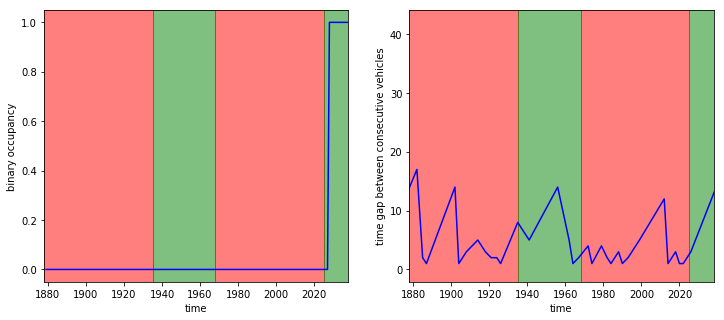

breakpoints in phase 21
2026
2047
Breakpoint C found!
Breakpoint: 2057 Time Gap: 2


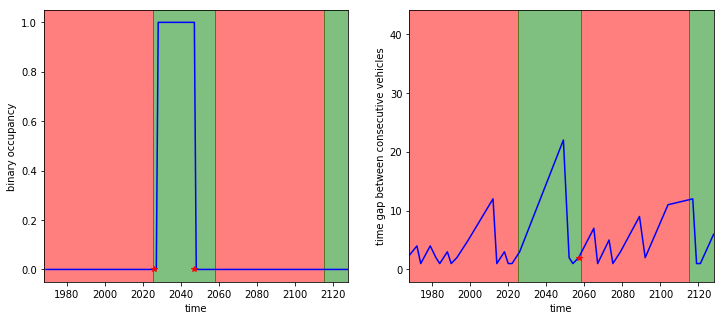

No reliable breakpoints in phase 22 found!
No breakpoint C in phase 22 found!


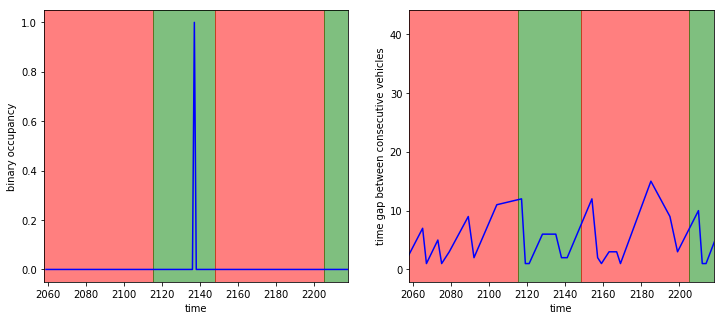

No reliable breakpoints in phase 23 found!
No breakpoint C in phase 23 found!


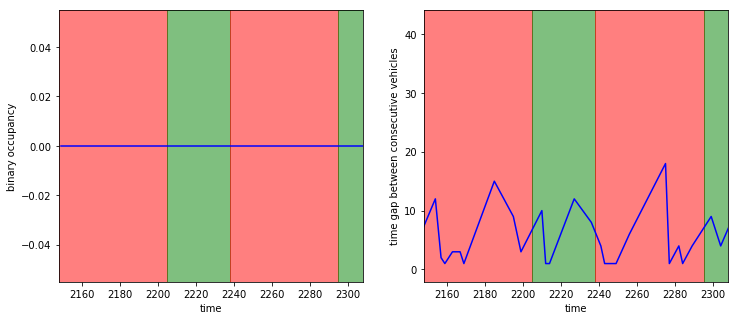

No reliable breakpoints in phase 24 found!
No breakpoint C in phase 24 found!


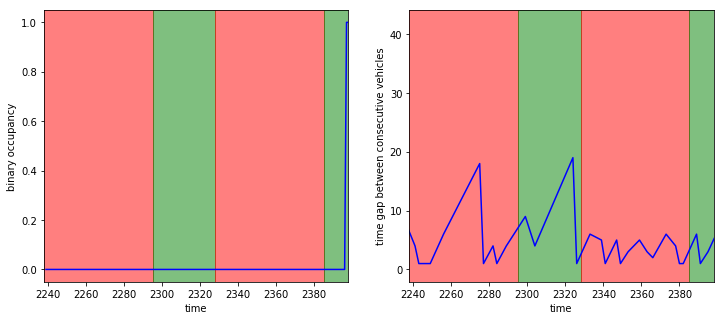

breakpoints in phase 25
2395
2406
Breakpoint C found!
Breakpoint: 2422 Time Gap: 1


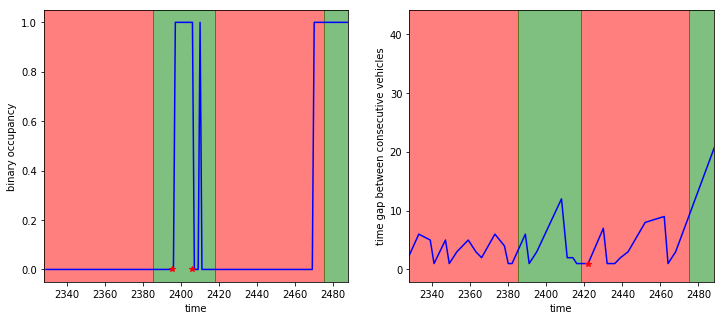

breakpoints in phase 26
2468
2497
Breakpoint C found!
Breakpoint: 2508 Time Gap: 1


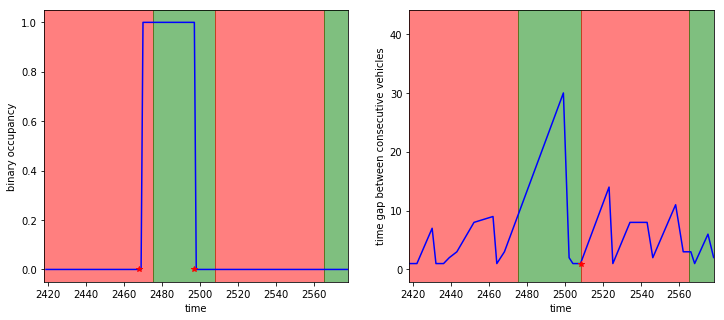

No reliable breakpoints in phase 27 found!
No breakpoint C in phase 27 found!


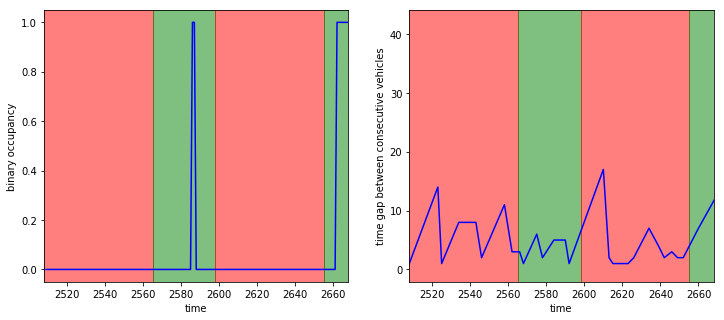

breakpoints in phase 28
2660
2677
Breakpoint C found!
Breakpoint: 2698 Time Gap: 1


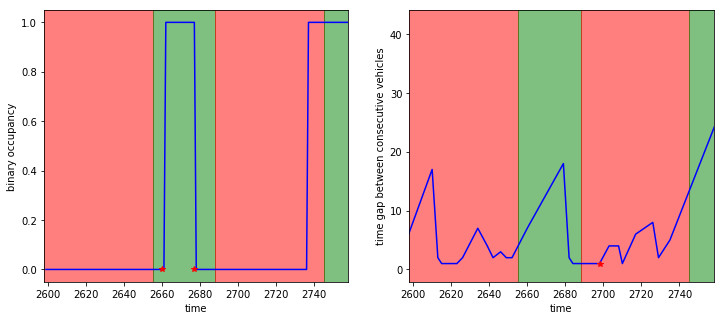

breakpoints in phase 29
2735
2767
Breakpoint C found!
Breakpoint: 2794 Time Gap: 2


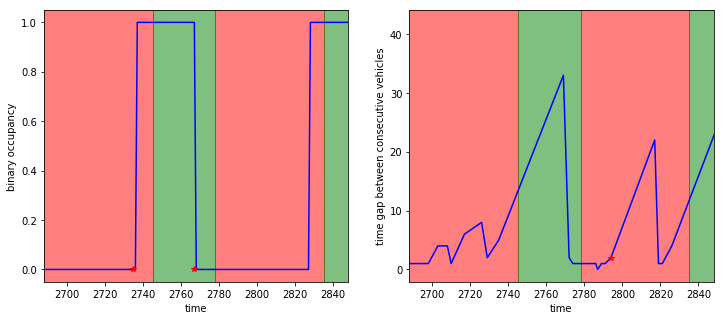

breakpoints in phase 30
2826
2857
Breakpoint C found!
Breakpoint: 2883 Time Gap: 1


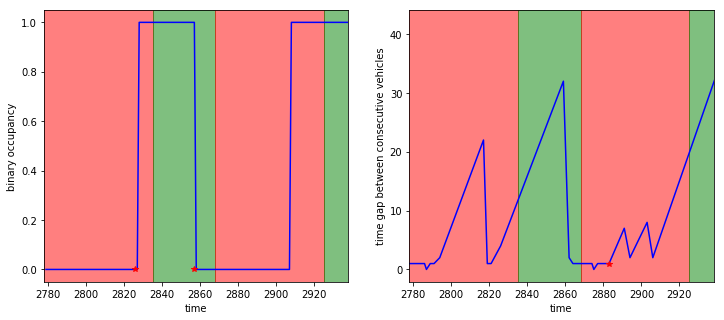

breakpoints in phase 31
2906
2947
Breakpoint C found!
Breakpoint: 2965 Time Gap: 3


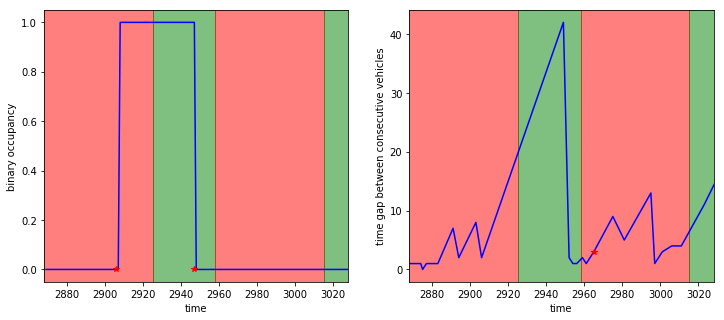

No reliable breakpoints in phase 32 found!
No breakpoint C in phase 32 found!


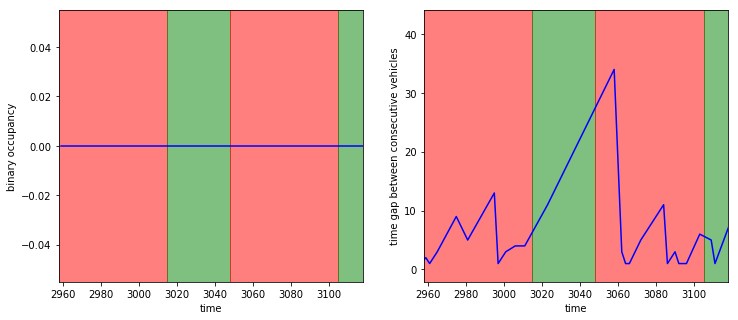

No reliable breakpoints in phase 33 found!
No breakpoint C in phase 33 found!


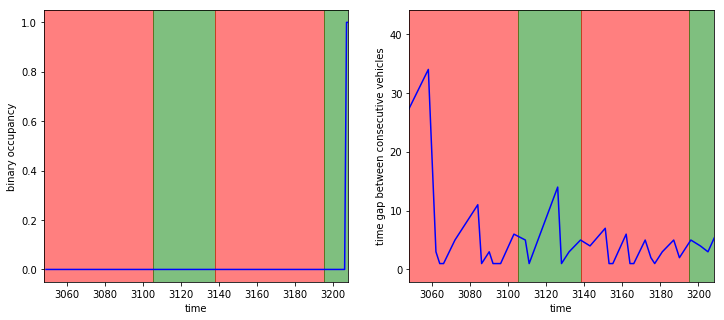

breakpoints in phase 34
3205
3217
Breakpoint C found!
Breakpoint: 3241 Time Gap: 1


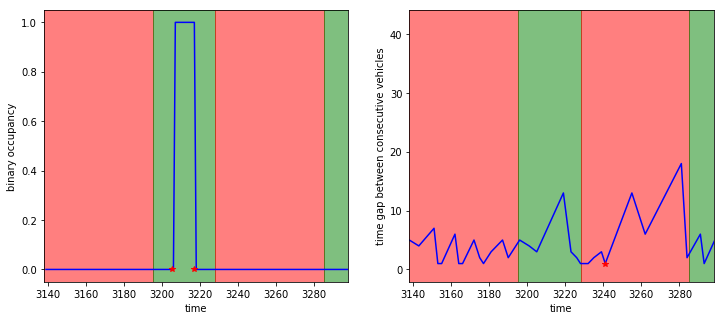

No reliable breakpoints in phase 35 found!
No breakpoint C in phase 35 found!


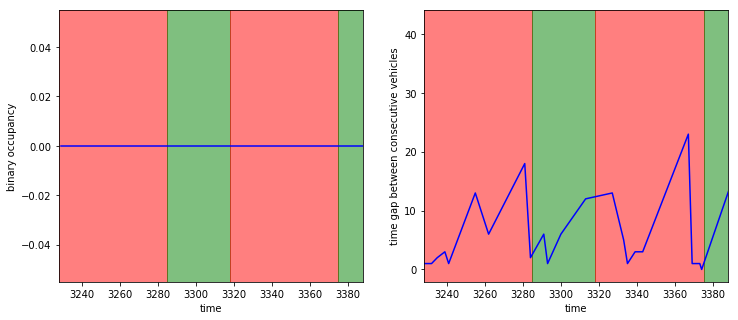

No reliable breakpoints in phase 36 found!
No breakpoint C in phase 36 found!


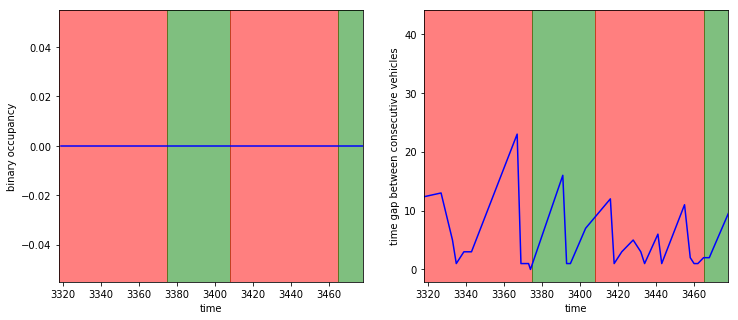

No reliable breakpoints in phase 37 found!
No breakpoint C in phase 37 found!


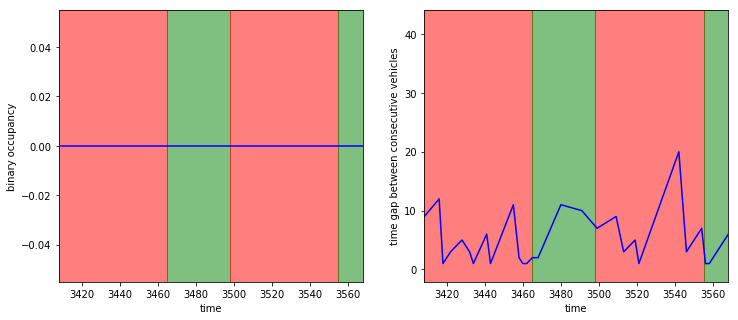

No reliable breakpoints in phase 38 found!
No breakpoint C in phase 38 found!


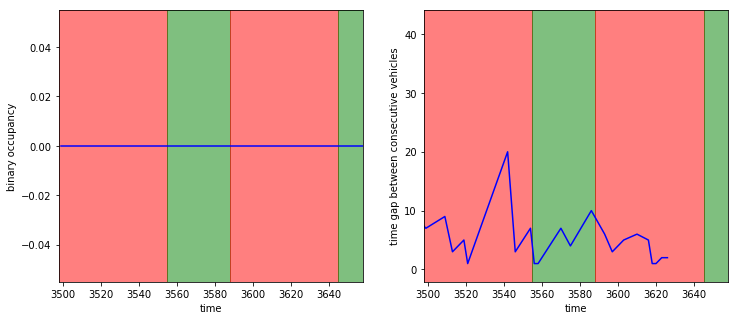

,breakpoint_A,breakpoint_B,breakpoint_C
0,137.0,157.0,178.0
1,244.0,248.0,259.0
2,311.0,337.0,361.0
3,396.0,427.0,448.0
4,476.0,517.0,537.0


In [78]:
### automatically detection of Breakpoint A, B, C ###

#initialize the storage:
arr_breakpoint_A = np.zeros(39)
arr_breakpoint_B = np.zeros(39)
arr_breakpoint_C = np.zeros(39)

phase_length = int(df_traffic_lights['begin'].values[1] - df_traffic_lights['begin'].values[0])
duration_green_light = int(df_traffic_lights['duration'].values[0])

for num_phase in range(0, 39):

    start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
    end = start + phase_length #seconds #end is end of green phase

    #Calculate detector occupancy time and binary occupancy
    detector_occupancy_time = []
    occ_t = df_detector.loc[:, 'occupancy']
    binary_occ_t = pd.Series()
    binary_occ_t = occ_t.apply(lambda x:(1 if x >= 100 else 0))

    #Calculate effective detector occupancy time
    cnt=0
    for t in range(0, df_rows):
        if binary_occ_t[t].values[0]==0:
            detector_occupancy_time.append(0)
        else:
            if binary_occ_t[t+1].values[0] == 1:
                detector_occupancy_time.append(cnt)
                cnt = cnt+1  
            else:
                detector_occupancy_time.append(cnt)
                cnt=0
    
    #Calculating the time gap between vehicles
    #I am assuming that there is maximum only one vehicle per second on the detector
    point_of_time = []
    time_gap_vehicles = []
    bool_start_timer =0
    time_cnt=0

    for t in range(0, df_rows):
        if nVehEnter_t[t].values[0] ==1: #new vehicle enters the detector: start timer new timer and save old measurements
            time_gap_vehicles.append(time_cnt)
            point_of_time.append(t)
            time_cnt=0 #reset time counter for new timing

        if nVehEnter_t[t].values[0]==0: #timer is running, following vehicle hasn't come yet
            time_cnt= time_cnt+1    

    ### Characterize the Breakpoints A,B ###
    ### A & B ### use the binary occupancy: 
    #We should point out that second-by-second percentage occupancy data can also be utilized to identify point A, i.e., the occupancy value
    #is kept at 100% for more than 3 s.(Liu paper, page 417)
    bool_A_found = 0
    bool_B_found = 0
    breakpoint_A = 0
    breakpoint_B = 0

    for t in range(start, end):

        if bool_A_found == 0 and binary_occ_t[t].values[0] == 0 and binary_occ_t[t+1].values[0] == 1 and binary_occ_t[t+2].values[0] == 1 and binary_occ_t[t+3].values[0] == 1:
            breakpoint_A = t
            bool_A_found = 1

        if bool_A_found == 1 and bool_B_found == 0 and binary_occ_t[t-3].values[0] == 1 and binary_occ_t[t-2].values[0] == 1 and binary_occ_t[t-1].values[0] == 1 and binary_occ_t[t].values[0] == 0:
            breakpoint_B = t
            bool_B_found = 1
            
    if bool_A_found == 1 and bool_B_found == 1:   
        print("breakpoints in phase", num_phase)
        print(breakpoint_A)
        print(breakpoint_B)
        arr_breakpoint_A[num_phase]=breakpoint_A  #store breakpoints
        arr_breakpoint_B[num_phase]=breakpoint_B  #store breakpoints
    else:
        print("No reliable breakpoints in phase", num_phase, "found!")
        arr_breakpoint_A[num_phase]= -1  #store breakpoints
        arr_breakpoint_B[num_phase]= -1  #store breakpoints        
        
    ### Characterizing Breakpoint C ### using time gap between consecutive vehicles
    bool_C_found =0
    breakpoint_C = 0
    start_search = breakpoint_B + 10 #start searching for C after the breakpoint B + 10 seconds and until end; little offset of 10 sec is necessary to avoid influence from breakpoint B
    end_search = end + 50
###ATTENTION!! Breakpoint k-1 chosen!!! (alternative k)
    for k in range(0, len(point_of_time)-1):
        if point_of_time[k] >= start_search and point_of_time[k] <= end_search and time_gap_vehicles[k] >= 4 and time_gap_vehicles[k] >= time_gap_vehicles[k+1] and time_gap_vehicles[k] >= time_gap_vehicles[k-1] and bool_C_found ==0 and bool_B_found ==1:
            print("Breakpoint C found!")
            print("Breakpoint:", point_of_time[k-1], "Time Gap:", time_gap_vehicles[k-1])
            breakpoint_C = point_of_time[k-1]
            index_C = k-1
            bool_C_found = 1
            arr_breakpoint_C[num_phase] = breakpoint_C  #store breakpoints

    if bool_C_found == 0:
        print("No breakpoint C in phase", num_phase, "found!") 
        arr_breakpoint_C[num_phase] = -1  #store breakpoints
        
    ### PLOT ###
   
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(12)

    #Plot binary_occ_t
    plt.subplot(1,2,1)
    plt.plot(df_detector['end'][start:end_search+20], binary_occ_t[start:end_search+20], c='b')
    plt.ylabel("binary occupancy")
    plt.xlabel("time")
    plt.xlim((start,end_search+20))
    plt.axvspan(start, end-df_traffic_lights['duration'].values[0], alpha=0.5, color='red')
    plt.axvspan(end-df_traffic_lights['duration'].values[0], end, alpha=0.5, color='green')
    plt.axvspan(end, end+phase_length-df_traffic_lights['duration'].values[0], alpha=0.5, color='red')
    plt.axvspan(end+phase_length-df_traffic_lights['duration'].values[0], end+phase_length, alpha=0.5, color='green')
    if bool_A_found == 1 and bool_B_found == 1:
        plt.plot(breakpoint_A, 0, 'r*')
        plt.plot(breakpoint_B, 0, 'r*') 
        
        
    plt.subplot(1,2,2)
    plt.plot(point_of_time, time_gap_vehicles, c='b')
    plt.ylabel("time gap between consecutive vehicles")
    plt.xlabel("time")
    plt.xlim((start,end_search+20))
    plt.axvspan(start, end-df_traffic_lights['duration'].values[0], alpha=0.5, color='red')
    plt.axvspan(end-df_traffic_lights['duration'].values[0], end, alpha=0.5, color='green')
    plt.axvspan(end, end+phase_length-df_traffic_lights['duration'].values[0], alpha=0.5, color='red')
    plt.axvspan(end+phase_length-df_traffic_lights['duration'].values[0], end+phase_length, alpha=0.5, color='green')
    if bool_C_found == 1:
        plt.plot(breakpoint_C, time_gap_vehicles[index_C], 'r*')
            
    plt.show() 

# put all arrays in a dataframe
df_breakpoints = pd.DataFrame()
df_breakpoints['breakpoint_A'] = arr_breakpoint_A
df_breakpoints['breakpoint_B'] = arr_breakpoint_B
df_breakpoints['breakpoint_C'] = arr_breakpoint_C
df_breakpoints.head()

In [79]:
##Estimating the density for congestion### -> result: jam_density is 0.2 (vehicles/meter)
## Counting density in simulation is 0.13333 vehicles per meter -> I will use this value!!!

df_e2_detector = pd.DataFrame()
df_e2_detector = graph.node[lane]['detectors']['e2_1-3to1-2_0_0']['data_series']
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_e2_detector[180:260])

df_e1_stopbar = pd.DataFrame()
df_e1_stopbar = graph.node[lane]['detectors']['e1_1-3to1-2_0_0']['data_series']

num_phase = 20
start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
end = start + phase_length #seconds #end is end of green phase


#df_e1_detector_dummy = graph.node[lane]['detectors']['e1_1-3to1-2_0_1']['data_series']
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(df_e1_detector_dummy[180:260])


                   end  sampledSeconds  nVehEntered  nVehLeft  nVehSeen  \
time node_id                                                              
180  1/3to1/2_0  181.0           10.00          0.0       0.0      10.0   
181  1/3to1/2_0  182.0           10.00          0.0       0.0      10.0   
182  1/3to1/2_0  183.0           10.50          1.0       0.0      11.0   
183  1/3to1/2_0  184.0           11.00          0.0       0.0      11.0   
184  1/3to1/2_0  185.0           11.53          1.0       0.0      12.0   
185  1/3to1/2_0  186.0           12.00          0.0       0.0      12.0   
186  1/3to1/2_0  187.0           12.00          0.0       0.0      12.0   
187  1/3to1/2_0  188.0           12.00          0.0       0.0      12.0   
188  1/3to1/2_0  189.0           12.00          0.0       0.0      12.0   
189  1/3to1/2_0  190.0           12.00          0.0       0.0      12.0   
190  1/3to1/2_0  191.0           12.00          0.0       0.0      12.0   
191  1/3to1/2_0  192.0   

17.0


/home/simon/anaconda3/envs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


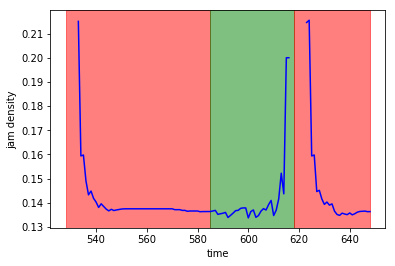

In [73]:
df_e2_detector['jam_density'] = df_e2_detector['meanMaxJamLengthInVehicles']/df_e2_detector['maxJamLengthInMeters']

num_phase =5 # select the number of phase
phase_length = int(df_traffic_lights['begin'].values[1] - df_traffic_lights['begin'].values[0])
duration_green_light = int(df_traffic_lights['duration'].values[0])
start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
end = start + phase_length #seconds #end is end of green phase
end_search = end + 10

#Plot density
plt.plot(df_e2_detector['end'][start:end_search+20], df_e2_detector['jam_density'][start:end_search+20], c='b')
plt.ylabel("jam density")
plt.xlabel("time")
plt.axvspan(start, end-33, alpha=0.5, color='red')
plt.axvspan(end-33, end, alpha=0.5, color='green')
plt.axvspan(end, end_search+20, alpha=0.5, color='red')
plt.plot()

# calculating traffic saturation flow (when vehicles are leaving the lane during green trafficlight)
sum_veh_left = 0
sum_veh_left = sum(df_e2_detector['nVehLeft'][end-duration_green_light:end])
print(sum_veh_left) # 17 vehicle / 33 seconds green light drucation = 0,5151 veh/sec


v3 =  5.626
real_max_queue:  165.00412510312756
Estimated v_2:  5.545454545454546
Liu method basic model in phase 0
real_max_queue:  135.0033750843771
Estimated v_2:  5.304347826086956
Liu method basic model in phase 1
real_max_queue:  202.50506262656566
Estimated v_2:  5.545454545454546
Liu method basic model in phase 2
real_max_queue:  202.50506262656566
Estimated v_2:  5.545454545454546
Liu method basic model in phase 3
real_max_queue:  217.5054376359409
Estimated v_2:  5.545454545454546
Liu method basic model in phase 4
real_max_queue:  202.50506262656566
Estimated v_2:  5.545454545454546
Liu method basic model in phase 5
real_max_queue:  165.00412510312756
Estimated v_2:  5.304347826086956
Liu method basic model in phase 6
real_max_queue:  172.5043126078152
Estimated v_2:  5.809523809523809
Liu method basic model in phase 7
real_max_queue:  172.5043126078152
Estimated v_2:  5.545454545454546
Liu method basic model in phase 8
real_max_queue:  150.00375009375233
simple input-output 

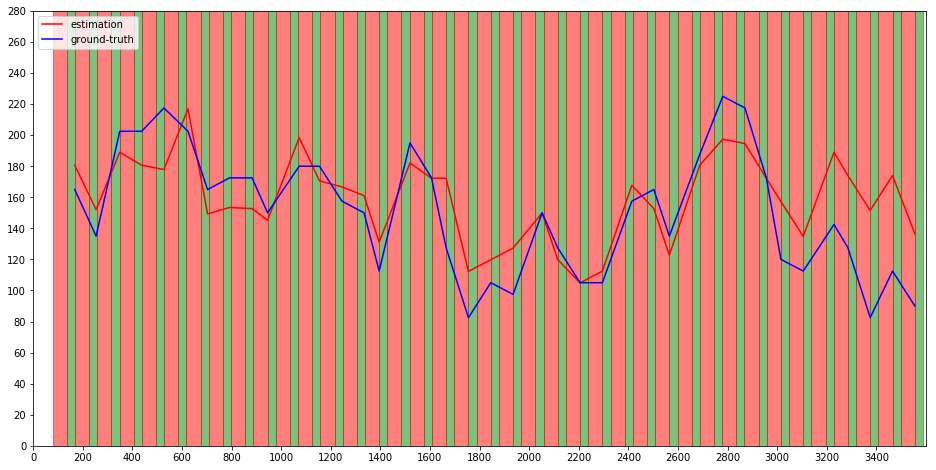

In [82]:
### Implementing queue length estimation ###

#assumptions
k_j = 0.13333 #jam density
k_m = 3/70 #discharge density(estimated from simulation in sumo-gui)
#k_m = 0.05015 #discharge density(estimated from e1 sensor data and Liu formula)
k_a = 0.013851 #arrival density

q_m = 2050/3600 #veh/second # dischage flow
q_a = 0.1818 #arrival flow
L_d = 122 #meters; distance from stopbar to e1 detector

# calculating discharge shockwave velocity v_2
#v_2 = q_m/(k_m-k_j) #discharge velocity 
#v_3 = (q_m-q_a)/(k_m-k_a)

#testing
#v_2 =  -2
#v_3 = 3

#counting from sumo simu
#v_2 =  -6.77
v_3 =  5.626
print('v3 = ', v_3)

#initializing
time_max_queue = np.zeros(39) #initialize value + 39 phases
estimated_max_queue_meters = np.zeros(39)
estimated_max_queue_nVeh = np.zeros(39)
real_max_queue_meters = np.zeros(39)
real_max_queue_nVeh = np.zeros(39)


phase_length = int(df_traffic_lights['begin'].values[1] - df_traffic_lights['begin'].values[0])
duration_green_light = int(df_traffic_lights['duration'].values[0])
start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
end = start + phase_length #seconds #end is end of green phase

for num_phase in range(0, 39): #39 phases

    start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
    end = start + phase_length #seconds #end is end of green phase
    
    real_max_queue_nVeh[num_phase] = sum(df_e2_detector['startedHalts'][start:end])
    real_max_queue_meters[num_phase] = real_max_queue_nVeh[num_phase]/k_j
    print('real_max_queue: ', real_max_queue_meters[num_phase])
    
    #print('start:', start, ' end:', end)
    
    #check if breakpoint A exists
    if arr_breakpoint_A[num_phase] == -1: #no breakpoint A exists -> short queue estimation method
        
        #simple input-output method
        print('simple input-output method in Phase', num_phase)
        #output, vehicles who are leaving the lane during green phase can be max 17
        #input is number of vehicles who pass the detector
        old_estimated_queue_nVeh = estimated_max_queue_nVeh[num_phase-1] #-2, because num_phase starts at 1
        #old estimation without stopbar e1 detector
        estimated_queue_nVeh = max(old_estimated_queue_nVeh - 17 + sum(df_detector["nVehContrib"][start-duration_green_light-8:start-8]), 0)+ sum(df_detector["nVehContrib"][start-8:end-duration_green_light])
        #new estimation with stopbar e1 detector
        estimated_queue_nVeh = max(old_estimated_queue_nVeh+sum(df_detector["nVehContrib"][start-duration_green_light:end-duration_green_light])- sum(df_e1_stopbar["nVehContrib"][start-duration_green_light:end-duration_green_light]), 0)   
        
        #store results
        estimated_max_queue_nVeh[num_phase]= estimated_queue_nVeh
        estimated_max_queue_meters[num_phase] = estimated_queue_nVeh/k_j
        time_max_queue[num_phase] = end-duration_green_light
        
    else:
        breakpoint_A = arr_breakpoint_A[num_phase]
        breakpoint_B = arr_breakpoint_B[num_phase]
        
        if arr_breakpoint_C[num_phase] == -1:
            print('OVERSATURATION, no Breakpoint C found!!!')
            #f point C cannot be identified, as we discussed in the last section, the approach is under oversaturation. The queue length under
            #oversaturated condition is difficult to estimate, but it is longer than or equal to the distance that occupied by the maximum
            #dischargeable queue during green time
            
            #we assume that the queue length is equal or bigger than the last estimated queue length
            estimated_max_queue_nVeh[num_phase] = estimated_max_queue_nVeh[num_phase-1]
            estimated_max_queue_meters[num_phase] = estimated_max_queue_nVeh[num_phase-1]/k_j
            time_max_queue[num_phase] = end-duration_green_light            

            
        else:
            breakpoint_C = arr_breakpoint_C[num_phase]
            
            ### Attention!!!-> use abs(v_2)!!! mistake in paper!
            v_2 = L_d/(breakpoint_B-(end-duration_green_light))
            print("Estimated v_2: ", v_2)
      ### Extension I      
            #print('Liu method extension I in phase', num_phase)
            #n is the number of vehicles passing detector between T_ng(start red phase) and T_C (breakpoint C)
            #n = sum(df_detector["nVehEntered"][(end-duration_green_light):breakpoint_C])
            #L_max = n/k_j + L_d
            #T_max = (end-duration_green_light) + L_max/abs(v_2)
      ###
    
      ### Basic Model
            print('Liu method basic model in phase', num_phase)
            L_max = L_d + (breakpoint_C-breakpoint_B)/(1/abs(v_2)+1/v_3)
            T_max = breakpoint_B + (L_max-L_d)/abs(v_2)
        
      ### 
            #store results
            estimated_max_queue_meters[num_phase] = L_max
            estimated_max_queue_nVeh[num_phase] = L_max*k_j
            time_max_queue[num_phase] = T_max
            
print(estimated_max_queue_nVeh)
print(estimated_max_queue_meters)
print(time_max_queue)

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)
estimation, = plt.plot(time_max_queue, estimated_max_queue_meters, c='r', label= 'estimation')
#plt.plot(df_e2_detector['end'], df_e2_detector['meanMaxJamLengthInVehicles']/k_j, c='b')
ground_truth, = plt.plot(time_max_queue, real_max_queue_meters, c='b', label= 'ground-truth')

plt.xticks(np.arange(0, 3600, 200))
plt.yticks(np.arange(0, 300, 20))
plt.xlim(0,3600)
for num_phase in range(0,39):
    start = int(df_traffic_lights['end'].values[0] + num_phase*phase_length) #seconds #start begins with red phase
    end = start + phase_length #seconds #end is end of green phase
    plt.axvspan(start, end-df_traffic_lights['duration'].values[0], alpha=0.5, color='red')
    plt.axvspan(end-df_traffic_lights['duration'].values[0], end, alpha=0.5, color='green')
    
plt.legend(handles=[estimation, ground_truth])
plt.show()